In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (val_images, val_labels) = mnist.load_data()

train_images = (train_images.astype('float32') - 127.5) / 127.5
val_images = (val_images.astype('float32') - 127.5) / 127.5

train_images = tf.expand_dims(train_images, axis=-1)
val_images = tf.expand_dims(val_images, axis=-1)

train_images = tf.cast(train_images, tf.float32)
val_images = tf.cast(val_images, tf.float32)

print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


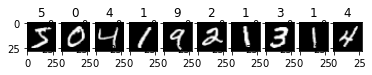

In [3]:
fig = plt.figure()
for i in range(10):
    img = np.reshape(train_images[i], (28, 28))
    ax = fig.add_subplot(1, 10, i+1)
    ax.set_title(str(train_labels[i]))
    plt.imshow(img, cmap='gray')

In [4]:
sample_images = train_images[0:10, :, :]
print(sample_images.shape)

(10, 28, 28, 1)


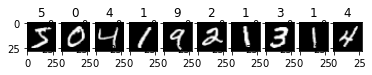

In [5]:
fig = plt.figure()
for i in range(10):
    img = np.reshape(sample_images[i], (28, 28))
    ax = fig.add_subplot(1, 10, i+1)
    ax.set_title(str(train_labels[i]))
    plt.imshow(img, cmap='gray')

In [6]:
train_ds = (tf.data.Dataset.from_tensor_slices(train_images)
                        .cache()
                        .shuffle(10000)
                        .batch(128)
)
val_ds = (tf.data.Dataset.from_tensor_slices(val_images)
                          .cache()
                          .batch(128)
)

In [7]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, filter_nums):
        super(Encoder, self).__init__()
        
        seq = []
        for i, filter_num in enumerate(filter_nums):
            if i != len(filter_nums) - 1:
                seq.append(tf.keras.layers.Conv2D(filter_num, 3, padding='same', activation='relu'))
                seq.append(tf.keras.layers.MaxPool2D((2, 2), padding='same'))
            else:
                seq.append(tf.keras.layers.Conv2D(filter_num, 3, padding='same'))
        
        self.model = tf.keras.Sequential(seq)

    def call(self, x):
        return self.model(x)

In [8]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, filter_nums):
        super(Decoder, self).__init__()

        seq = []
        for i, filter_num in enumerate(filter_nums):
            if i != len(filter_nums) - 1:
                seq.append(tf.keras.layers.Conv2DTranspose(filter_num, 3, padding='same', activation='relu'))
                seq.append(tf.keras.layers.UpSampling2D((2, 2)))
            else:
                seq.append(tf.keras.layers.Conv2DTranspose(filter_num, 3, padding='same'))
        
        self.model = tf.keras.Sequential(seq)
    
    def call(self, x):
        return self.model(x)

In [9]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, encoder_filter_nums, input_size):
        assert input_size[0] >= 2**(len(encoder_filter_nums)-1)
        assert input_size[0] % 2**(len(encoder_filter_nums)-1) == 0

        super(AutoEncoder, self).__init__()  
        self.encoder_filter_nums = encoder_filter_nums
        self.encoder = Encoder(encoder_filter_nums)

        decoder_filter_nums = encoder_filter_nums[-2::-1] + [1]        
        self.decoder = Decoder(decoder_filter_nums)

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = AutoEncoder([2, 4, 8], (28, 28))

loss_obj = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

output_dir = 'output'
model_id = 'filter_nums'
for filter_num in model.encoder_filter_nums:
    model_id += '_' + str(filter_num)
checkpoint_path = os.path.join(output_dir, 'checkpoints', model_id)
log_dir = os.path.join(output_dir, 'logs', model_id)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
summary_writer = tf.summary.create_file_writer(log_dir)
tf.summary.trace_on(graph=True, profiler=False)

In [12]:
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        preds = model(inputs)
        loss = loss_obj(targets, preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

@tf.function
def val_step(inputs, targets):
    preds = model(inputs)
    loss = loss_obj(targets, preds)

    val_loss(loss)

In [13]:
image = next(iter(train_ds))

with summary_writer.as_default():
    func_graph = val_step.get_concrete_function(image, image).graph
    tf.python.ops.summary_ops_v2.graph(func_graph.as_graph_def(), step=0)

model.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  392       
_________________________________________________________________
decoder (Decoder)            multiple                  385       
Total params: 777
Trainable params: 777
Non-trainable params: 0
_________________________________________________________________


In [14]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

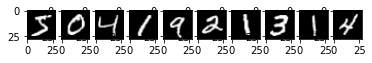

In [15]:
fig = plt.figure()
for i in range(10):
    img = np.reshape(sample_images[i], (28, 28))
    ax = fig.add_subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')

In [16]:
iter_num = len(list(train_ds))

EPOCHS = 50

for epoch in range(EPOCHS):
    train_loss.reset_states()
    val_loss.reset_states()

    probar = tf.keras.utils.Progbar(iter_num)
    for (step_idx, images) in enumerate(train_ds):
        train_step(images, images)
        probar.add(1)

    for (step_idx, images) in enumerate(val_ds):
        val_step(images, images)
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Save checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path))

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('val_loss', val_loss.result(), step=epoch)

    print(f'Epoch {epoch}\
         Loss {train_loss.result():.4f}\
         Val_Loss {val_loss.result():.4f}')


469/469 [==============================] - 3s 6ms/step
Epoch 0         Loss 0.4633         Val_Loss 0.1773
469/469 [==============================] - 1s 2ms/step
Epoch 1         Loss 0.1482         Val_Loss 0.1145
469/469 [==============================] - 1s 2ms/step
Epoch 2         Loss 0.1046         Val_Loss 0.0974
469/469 [==============================] - 1s 2ms/step
Epoch 3         Loss 0.0959         Val_Loss 0.0927
469/469 [==============================] - 1s 2ms/step
Saving checkpoint for epoch 4 at output\checkpoints\filter_nums_2_4_8\ckpt-1
Epoch 4         Loss 0.0918         Val_Loss 0.0888
469/469 [==============================] - 1s 2ms/step
Epoch 5         Loss 0.0891         Val_Loss 0.0866
469/469 [==============================] - 1s 2ms/step
Epoch 6         Loss 0.0857         Val_Loss 0.0808
469/469 [==============================] - 1s 2ms/step
Epoch 7         Loss 0.0806         Val_Loss 0.0780
469/469 [==============================] - 1s 2ms/step
Epoch 8     

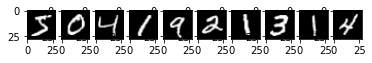

In [17]:
fig = plt.figure()
for i in range(10):
    img = np.reshape(sample_images[i], (28, 28))
    ax = fig.add_subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')

In [18]:
# checkpoint = tf.train.Checkpoint(model=model)
# checkpoint.restore('output/checkpoints/ckpt-8')

(10, 28, 28, 1)
(10, 28, 28, 1)


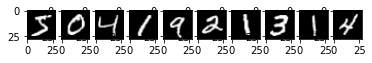

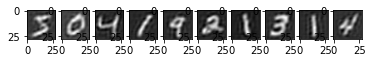

In [19]:
sample_output = model(sample_images)
print(sample_images.shape)
print(sample_output.shape)


fig = plt.figure()
for i in range(10):
    img = np.reshape(sample_images[i], (28, 28))
    ax = fig.add_subplot(2, 10, i+1)
    plt.imshow(img, cmap='gray')

fig = plt.figure()
for i in range(10):   
    img = np.reshape(sample_output[i], (28, 28))
    ax = fig.add_subplot(2, 10, i+11)
    plt.imshow(img, cmap='gray')

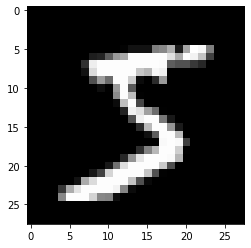

In [20]:
demo_input_image = sample_images[0]
demo_output_image = sample_output[0]

fig = plt.figure()
img = np.reshape(demo_input_image, (28, 28))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(img, cmap='gray')

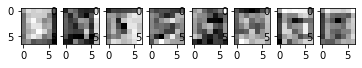

In [21]:
demo_encoder_output = model.encoder(demo_input_image[tf.newaxis, ...])

fig = plt.figure()

encoder_output_size = demo_encoder_output.shape[-1]
for i in range(encoder_output_size):
    img = np.reshape(demo_encoder_output[0, :, :, i], (7, 7))
    ax = fig.add_subplot(1, encoder_output_size, i+1)
    plt.imshow(img, cmap='gray')